# 04 Manual Strategy

#### Purpose
Compare manual strategy, example using Bollinger Bands with RSI, and theoretically maximum return.

In [1]:
!conda env list

# conda environments:
#
base                     /home/ubuntu/anaconda3
alert                    /home/ubuntu/anaconda3/envs/alert
aws_neuron_mxnet_p36     /home/ubuntu/anaconda3/envs/aws_neuron_mxnet_p36
aws_neuron_tensorflow_p36     /home/ubuntu/anaconda3/envs/aws_neuron_tensorflow_p36
chainer_p27              /home/ubuntu/anaconda3/envs/chainer_p27
chainer_p36              /home/ubuntu/anaconda3/envs/chainer_p36
ml                    *  /home/ubuntu/anaconda3/envs/ml
mxnet_p27                /home/ubuntu/anaconda3/envs/mxnet_p27
mxnet_p36                /home/ubuntu/anaconda3/envs/mxnet_p36
python2                  /home/ubuntu/anaconda3/envs/python2
python3                  /home/ubuntu/anaconda3/envs/python3
pytorch_p27              /home/ubuntu/anaconda3/envs/pytorch_p27
pytorch_p36              /home/ubuntu/anaconda3/envs/pytorch_p36
tensorflow2_p27          /home/ubuntu/anaconda3/envs/tensorflow2_p27
tensorflow2_p36          /home/ubuntu/anaconda3/envs/tensorflow2_p36
tensorflo

In [2]:
import sys
from pathlib import Path
# add project folder to sys path
sys.path.append(str(Path.cwd().parent))

In [19]:
# import libraries
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import helper functions
from util import get_data, plot_data, normalize, standard_score
from marketsimcode import compute_portvals, get_portfolio_stats, compute_daily_returns

# import strategy
import ManualStrategy as ms
import TheoreticallyOptimalStrategy as tos

In [10]:
CURRENT_DIR = Path.cwd()
PROJECT_DIR = Path.cwd().parent
ORDER_DIR = PROJECT_DIR / "orders"

In [11]:
# check orders file
orders_file = str(ORDER_DIR/"orders.csv")
df_orders = pd.read_csv(orders_file, index_col='Date', parse_dates=True, na_values=['nan'])
df_orders

,Symbol,Order,Shares
Date,,,
2011-01-10,AAPL,BUY,1500
2011-01-13,AAPL,SELL,1500
2011-01-13,IBM,BUY,4000
2011-01-26,GOOG,BUY,1000
2011-02-02,XOM,SELL,4000
2011-02-10,XOM,BUY,4000
2011-03-03,GOOG,SELL,1000
2011-03-03,IBM,SELL,2200
2011-06-03,IBM,SELL,3300


In [12]:
SYMBOL = "JPM"
IN_SAMPLE_DATES = (dt.datetime(2008, 1, 1), dt.datetime(2009, 12, 31))
OUT_SAMPLE_DATES = (dt.datetime(2010, 1, 1), dt.datetime(2011, 12, 31))
START_VAL = 100000

POSITIONS = [-1000, 0, 1000]

In [13]:
def benchmark(symbol, sd, ed, sv):
    """ Calculate benchmark strategy
    Benchmark strategy:
        Buy 1000 shares and hold, starting value 100000
    Order DataFrame:
        Date,       Symbol, Order,  Shares
        2010-01-04, JPM,    BUY,    1000

    Params:
    @symbol: the stock symbol to act on
    @sd: Start date of trading period
    @ed: End date of trading period
    @sv: Starting value

    Return:
    @df_benchmark: Dataframe for benchmark strategy
    """
    test_sd = sd
    test_ed = ed
    symbols = [symbol]

    # get price data
    df_prices = get_data(symbols, pd.date_range(test_sd, test_ed))
    # print(df_prices)
    start_date = min(df_prices.index)
    # print(start_date)

    orders = {'Date': [start_date],
              'Symbol': symbols,
              'Order': ['BUY'],
              'Shares': [1000]
              }

    df_orders = pd.DataFrame(orders)

    # df_orders['Date'] = pd.to_datetime(df_orders['Date'], format="%Y-%m-%d")
    df_orders.set_index('Date', inplace=True)
    # print("df_orders")
    # print(df_orders)
    # print(df_orders.info())

    # calcualte portfolio value based on trade orders (df_orders)
    portvals = compute_portvals(df_orders=df_orders,
                                start_val=START_VAL,
                                commission=9.95,
                                impact=0.005,
                                start_date=sd,
                                end_date=ed)

    # normalize the portvals
    portvals = normalize(portvals)

    cr, adr, sddr, sr = get_portfolio_stats(portvals)

    return portvals, cr, adr, sddr, sr

In [14]:
def test_code():
    start_date = OUT_SAMPLE_DATES[0]
    end_date = OUT_SAMPLE_DATES[1]

    df_trades_ms = ms.testPolicy(symbol=SYMBOL, sd=start_date, ed=end_date, sv=START_VAL)
    df_trades_tos = tos.testPolicy(symbol=SYMBOL, sd=start_date, ed=end_date, sv=START_VAL)
    # print("df_trades")
    # print(df_trades.head())
    # print(df_trades.tail())

    df_orders_ms = convert_trades_to_order(df_trades_ms)
    df_orders_tos = convert_trades_to_order(df_trades_tos)
    # print("df_orders")
    # print(df_orders)

    # calcualte portfolio value based on trade orders (df_orders)
    manual_strategy_portvals = compute_portvals(df_orders=df_orders_ms,
                                                start_val=START_VAL,
                                                commission=9.95,
                                                impact=0.005,
                                                start_date=start_date,
                                                end_date=end_date)

    optimal_strategy_portvals = compute_portvals(df_orders=df_orders_tos,
                                                 start_val=START_VAL,
                                                 commission=9.95,
                                                 impact=0.005,
                                                 start_date=start_date,
                                                 end_date=end_date)

    # normalize the portvals
    manual_strategy_portvals = normalize(manual_strategy_portvals)
    optimal_strategy_portvals = normalize(optimal_strategy_portvals)

    (cum_ret_manual_strategy, avg_daily_ret_manual_strategy,
     std_daily_ret_manual_strategy, sharpe_ratio_manual_strategy) = get_portfolio_stats(manual_strategy_portvals)

    (cum_ret_optimal_strategy, avg_daily_ret_optimal_strategy,
     std_daily_ret_optimal_strategy, sharpe_ratio_optimal_strategy) = get_portfolio_stats(optimal_strategy_portvals)

    # Get stats for benchmark performance
    (benchmark_portvals, benchmark_cum_ret, benchmark_avg_daily_ret,
     benchmark_std_daily_ret, benchmark_sharpe_ratio) = benchmark(symbol=SYMBOL,
                                                                  sd=start_date,
                                                                  ed=end_date,
                                                                  sv=START_VAL)

    print_compare_benchmark(start_date, end_date,
                            benchmark_sharpe_ratio,
                            sharpe_ratio_manual_strategy,
                            benchmark_cum_ret,
                            cum_ret_manual_strategy,
                            benchmark_std_daily_ret,
                            std_daily_ret_manual_strategy,
                            benchmark_avg_daily_ret,
                            avg_daily_ret_manual_strategy,
                            benchmark_portvals,
                            manual_strategy_portvals,
                            sharpe_ratio_optimal_strategy,
                            cum_ret_optimal_strategy,
                            std_daily_ret_optimal_strategy,
                            avg_daily_ret_optimal_strategy,
                            optimal_strategy_portvals)

    plot_compare(benchmark_portvals, optimal_strategy_portvals, manual_strategy_portvals)

In [15]:
def plot_compare(benchmark_portvals, optimal_strategy_portvals, manual_strategy_portvals):
    """Plot portfolio values of Benchmark and Manual Strategy"""
    final_df = pd.concat([benchmark_portvals, optimal_strategy_portvals, manual_strategy_portvals], axis=1)
    final_df.columns = ['Normalized Benchmark Portfolio Value',
                        'Normalized Theoretically Optimal Strategy Portfolio Value',
                        'Normalized Manual Strategy Portfolio Value'
                        ]
    # print(final_df)
    # Plot final dataframe
    title = "Benchmark vs Manual Strategy vs Theoretically Optimal Strategy - Out of Sample"
    xlabel = "Date"
    ylabel = "Portfolio Value"
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = final_df.plot(title=title, fontsize=12, color=['g', 'r', 'b'], figsize=(10, 6))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.axhline(y=1., color='m', linestyle=':')

    # # add blue lines for LONG entry points
    # for x in long_entry_points:
    #     plt.axvline(x=x, color='b', linestyle='--')

    # # add black lines for SHORT entry points
    # for x in short_entry_points:
    #     plt.axvline(x=x, color='k', linestyle='--')

    plt.show()
    return None

In [16]:
def convert_trades_to_order(df_trades):
    """ Convert df_trades to df_orders for calculating stats
    df_trades Example:
        Date,         trade
        2010-01-04,   +1000.0
    df_orders Example:
       Date,       Symbol, Order,  Shares
       2010-01-04, JPM,    BUY,    1000
    """
    df_orders = df_trades.copy()

    df_orders['Symbol'] = 'JPM'
    conditions = [
        (df_orders['trade'] > 0),
        (df_orders['trade'] < 0),
        (df_orders['trade'] == 0)]
    choices = ['BUY', 'SELL', 'HOLD']
    df_orders['Order'] = np.select(conditions, choices, default='HOLD')

    df_orders['Shares'] = np.abs(df_orders['trade'])

    # drop trade column
    df_orders.drop(['trade'], axis=1, inplace=True)

    # drop HOLD rows
    df_orders.drop(df_orders[df_orders['Order'] == "HOLD"].index, inplace=True)

    return df_orders

In [17]:
def print_compare_benchmark(start_date, end_date,
                            benchmark_sharpe_ratio,
                            sharpe_ratio_manual_strategy,
                            benchmark_cum_ret,
                            cum_ret_manual_strategy,
                            benchmark_std_daily_ret,
                            std_daily_ret_manual_strategy,
                            benchmark_avg_daily_ret,
                            avg_daily_ret_manual_strategy,
                            benchmark_portvals,
                            manual_strategy_portvals,
                            sharpe_ratio_optimal_strategy,
                            cum_ret_optimal_strategy,
                            std_daily_ret_optimal_strategy,
                            avg_daily_ret_optimal_strategy,
                            optimal_strategy_portvals):
    # Compare portfolio against $SPX
    print("Date Range: {} to {}".format(start_date, end_date))
    print()
    print("Sharpe Ratio of benchmark: {}".format(benchmark_sharpe_ratio))
    print("Sharpe Ratio of manual_strategy : {}".format(sharpe_ratio_manual_strategy))
    print("Sharpe Ratio of optimal_strategy : {}".format(sharpe_ratio_optimal_strategy))
    print()
    print("Cumulative Return of benchmark: {}".format(benchmark_cum_ret))
    print("Cumulative Return of manual_strategy : {}".format(cum_ret_manual_strategy))
    print("Cumulative Return of optimal_strategy : {}".format(cum_ret_optimal_strategy))
    print()
    print("Standard Deviation of benchmark: {}".format(benchmark_std_daily_ret))
    print("Standard Deviation of manual_strategy : {}".format(std_daily_ret_manual_strategy))
    print("Standard Deviation of optimal_strategy : {}".format(std_daily_ret_optimal_strategy))
    print()
    print("Average Daily Return of benchmark: {}".format(benchmark_avg_daily_ret))
    print("Average Daily Return of manual_strategy : {}".format(avg_daily_ret_manual_strategy))
    print("Average Daily Return of optimal_strategy : {}".format(avg_daily_ret_optimal_strategy))
    print()
    print("Final benchmark Portfolio Value: {}".format(benchmark_portvals[-1]))
    print("Final manual_strategy Portfolio Value: {}".format(manual_strategy_portvals[-1]))
    print("Final optimal_strategy Portfolio Value: {}".format(optimal_strategy_portvals[-1]))

Date Range: 2010-01-01 00:00:00 to 2011-12-31 00:00:00

Sharpe Ratio of benchmark: -0.2566565605198902
Sharpe Ratio of manual_strategy : 0.34369646719586805
Sharpe Ratio of optimal_strategy : 10.703771742086357

Cumulative Return of benchmark: -0.08357911003280027
Cumulative Return of manual_strategy : 0.07233450000000019
Cumulative Return of optimal_strategy : 2.036879532838884

Standard Deviation of benchmark: 0.008500158322332451
Standard Deviation of manual_strategy : 0.007821263908317987
Standard Deviation of optimal_strategy : 0.0032868060546365607

Average Daily Return of benchmark: -0.00013742923038916383
Average Daily Return of manual_strategy : 0.00016933695185519863
Average Daily Return of optimal_strategy : 0.002216208657644712

Final benchmark Portfolio Value: 0.9164208899671997
Final manual_strategy Portfolio Value: 1.0723345000000002
Final optimal_strategy Portfolio Value: 3.036879532838884


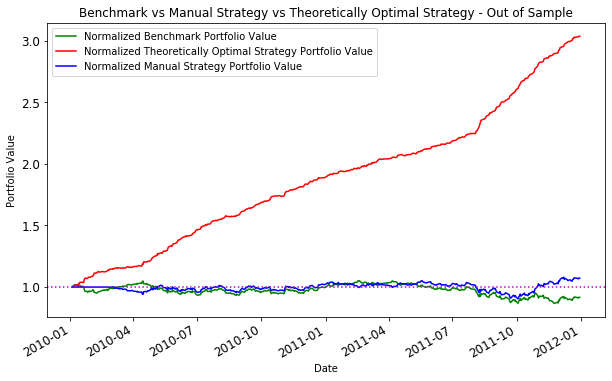

In [20]:
test_code()